In [ ]:
"""
Purpose: To test out the dive into
python library for explanability

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import sys
sys.path.append("/pytorch_tools/pytorch_tools/")

# SubgraphX Tutorial

## a) Getting the dataset

In [3]:
import torch
import os.path as osp
from dig.xgraph.dataset import SynGraphDataset
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
num_classes = dataset.num_classes

## b) Loading the Model (using pretrained model)

In [23]:
from dig.xgraph.utils.compatibility import compatible_state_dict
from torch_geometric.data import InMemoryDataset, download_url,extract_zip
import os

def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)

from dig.xgraph.models import GCN_2l
model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)
check_checkpoints()
ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
state_dict = compatible_state_dict(torch.load(ckpt_path, map_location='cpu')['state_dict'])
model.load_state_dict(state_dict)

<All keys matched successfully>

# c) Running the modele for a certain dataset

In [33]:
data = dataset[0].to(device)
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
node_idx_basic = 20
node_idx = node_indices[node_idx_basic]  # node_idx: 515
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(dim=-1)
# prediction class is 2, the middle node of the house motif

## d) Plotting a graph

In [36]:
subset

tensor([  1,   7,   9,  71,  83, 129, 144, 151, 154, 515, 516, 517, 518, 519])

In [37]:
subgraph_y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3])

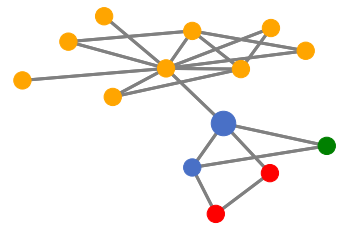

In [41]:
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, Batch
import numpy as np

subgraph_x, subgraph_edge_index, subset, edge_mask, kwargs = \
    MCTS.__subgraph__(node_idx, data.x, data.edge_index, num_hops=2)
subgraph_y = data.y[subset].to('cpu')
node_idx_subset = np.where(subset == node_idx)[0]
vis_graph = to_networkx(Data(x=subgraph_x, edge_index=subgraph_edge_index))
plotutils = PlotUtils(dataset_name='ba_shapes')
plotutils.plot(vis_graph, nodelist=subset, figname=None, y=subgraph_y, node_idx=node_idx_subset)

## e) Using Monte Carlo Tree Search to sample different subgraphs and compute the shapley values

In [42]:
from dig.xgraph.method import SubgraphX
explainer = SubgraphX(model, num_classes=4, device=device, explain_graph=False,
                        reward_method='nc_mc_l_shapley')

## f) Pick the subgraph with the highest important and plot the explanation

In [56]:
from dig.xgraph.method.subgraphx import find_closest_node_result
plotutils = PlotUtils(dataset_name='ba_shapes')

# Visualization
max_nodes = 5
node_idx = node_indices[node_idx_basic]
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

_, explanation_results, related_preds = \
    explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
result = find_closest_node_result(explanation_results[prediction], max_nodes=max_nodes)

plotutils = PlotUtils(dataset_name='ba_shapes')
explainer.visualization(result,
                        #prediction,
                        max_nodes=max_nodes,
                        plot_utils=plotutils,
                        y=data.y)

explain graph node 515


TypeError: string indices must be integers

In [57]:
debug

> /DIG/dig/xgraph/method/subgraphx.py(30)<lambda>()
     28         results = sorted(results, key=lambda x: len(x.coalition))
     29     except:
---> 30         results = sorted(results, key=lambda x: len(x["coalition"]))
     31 
     32     result_node = results[0]

ipdb> x
'data'
ipdb> c
